In [1]:
from torch.utils.data import DataLoader

import mapd
import torchvision
from torchvision import transforms

from mapd.probes.make_probe_suites import make_probe_suites
from mapd.probes.utils.idx_dataset import IDXDataset
from mapd.utils.make_dataloaders import make_dataloaders
from mapd.classifiers.make_mapd_classifier import make_mapd_classifier
%load_ext autoreload
%autoreload 2

In [2]:
MNIST_ROOT = "data-emnist"
torchvision.datasets.EMNIST(root=MNIST_ROOT, download=True, split="balanced")

Dataset EMNIST
    Number of datapoints: 112800
    Root location: data-emnist
    Split: Train

In [3]:
from torchvision.datasets import MNIST

In [4]:
from torch import nn


class Net(nn.Module):
    def __init__(self, num_labels: int = 10):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, num_labels)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x


model = Net(num_labels=47)

In [5]:
import numpy as np
import lightning as L
from torch.nn import functional as F
from torch.optim import SGD
import torch


class MNISTModule(mapd.MAPDModule):
    def __init__(
            self,
            max_epochs: int = 10,
            lr: float = 0.05,
            momentum: float = 0.9,
            weight_decay: float = 0.0005
    ):
        super().__init__()
        self.model = model

        self.max_epochs = max_epochs
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay

        self.save_hyperparameters(ignore=["model"])

    def mapd_settings(self):
        return {
            "proxy_metric": "loss",
            "proxy_metric_direction": "minimize",
        }

    def forward(self, x):
        return self.model(x)

    def batch_loss(self, logits, y) -> torch.Tensor:
        return F.cross_entropy(logits, y, reduction="none")

    def batch_proxy_metric(self, logits, y) -> torch.Tensor:
        return -self.batch_loss(logits, y)

    def training_step(self, batch, batch_idx):
        x, y = batch

        logits = self.forward(x)
        loss = self.batch_loss(logits, y).mean()
        self.mapd_log(logits, y)

        return loss

    def validation_step(self, batch, batch_idx, dataloader_idx: int = 0):
        x, y = batch

        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        self.mapd_log(logits, y)

        return loss

    def configure_optimizers(self):
        optimizer = SGD(
            self.parameters(),
            lr=self.lr
        )

        return {"optimizer": optimizer}

In [7]:
from torch.utils.data import random_split

module = MNISTModule()

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
target_transform = transforms.Compose([transforms.Lambda(lambda x: x)])
mnist_test = torchvision.datasets.EMNIST(MNIST_ROOT, train=False, split="balanced", transform=transform, target_transform=target_transform)
mnist_predict = torchvision.datasets.EMNIST(MNIST_ROOT, train=False, split="balanced", transform=transform, target_transform=target_transform)
mnist_full = torchvision.datasets.EMNIST(MNIST_ROOT, train=True, split="balanced", transform=transform, target_transform=target_transform)
mnist_train, mnist_val = random_split(mnist_full, [0.8, 0.2])
mnist_train = IDXDataset(mnist_train)

dl = DataLoader(mnist_train, batch_size=1024, shuffle=True, num_workers=4, prefetch_factor=2)

torch.set_float32_matmul_precision('medium')

trainer_proxy = L.Trainer(accelerator="cpu", max_epochs=100)
trainer_probes = L.Trainer(accelerator="cpu", max_epochs=100)

# Proxy
trainer_proxy.fit(module.as_proxies(), train_dataloaders=dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/fluisense/opt/anaconda3/envs/bsc/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/fluisense/opt/anaconda3/envs/bsc/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator

PicklingError: Can't pickle <function <lambda> at 0x7fb81a13b0a0>: attribute lookup <lambda> on __main__ failed

In [7]:
probe_suite_ds = make_probe_suites(mnist_train, 47, "proxies", num_probes=500)

In [8]:
dl_probes = DataLoader(mnist_train, batch_size=1024, shuffle=True, num_workers=16, prefetch_factor=4)

val_dataloader = DataLoader(IDXDataset(mnist_val), batch_size=1024, shuffle=False, num_workers=16, prefetch_factor=4)
val_dataloaders = make_dataloaders([val_dataloader], probe_suite_ds)

trainer_probes.fit(module.as_probes(probe_suite_ds), train_dataloaders=dl_probes, val_dataloaders=val_dataloaders)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | Net  | 23.7 K
-------------------------------
23.7 K    Trainable params
0         Non-trainable params
23.7 K    Total params
0.095     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/jonashoffmann/.applications/miniconda3/envs/mapd-pkg/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Traceback (most recent call last):
  File "/home/jonashoffmann/.applications/miniconda3/envs/mapd-pkg/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/jonashoffmann/.applications/miniconda3/envs/mapd-pkg/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/jonashoffmann/.applications/miniconda3/envs/mapd-pkg/lib/python3.9/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/jonashoffmann/.applicati

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [9]:
clf, label_encoder = make_mapd_classifier("probes", probe_suite_ds, clf="xgboost")

In [11]:
from mapd.classifiers.make_predictions import make_predictions

preds = make_predictions("probes", clf, label_encoder, n_jobs=16)

  0%|          | 0/16 [00:00<?, ?it/s]

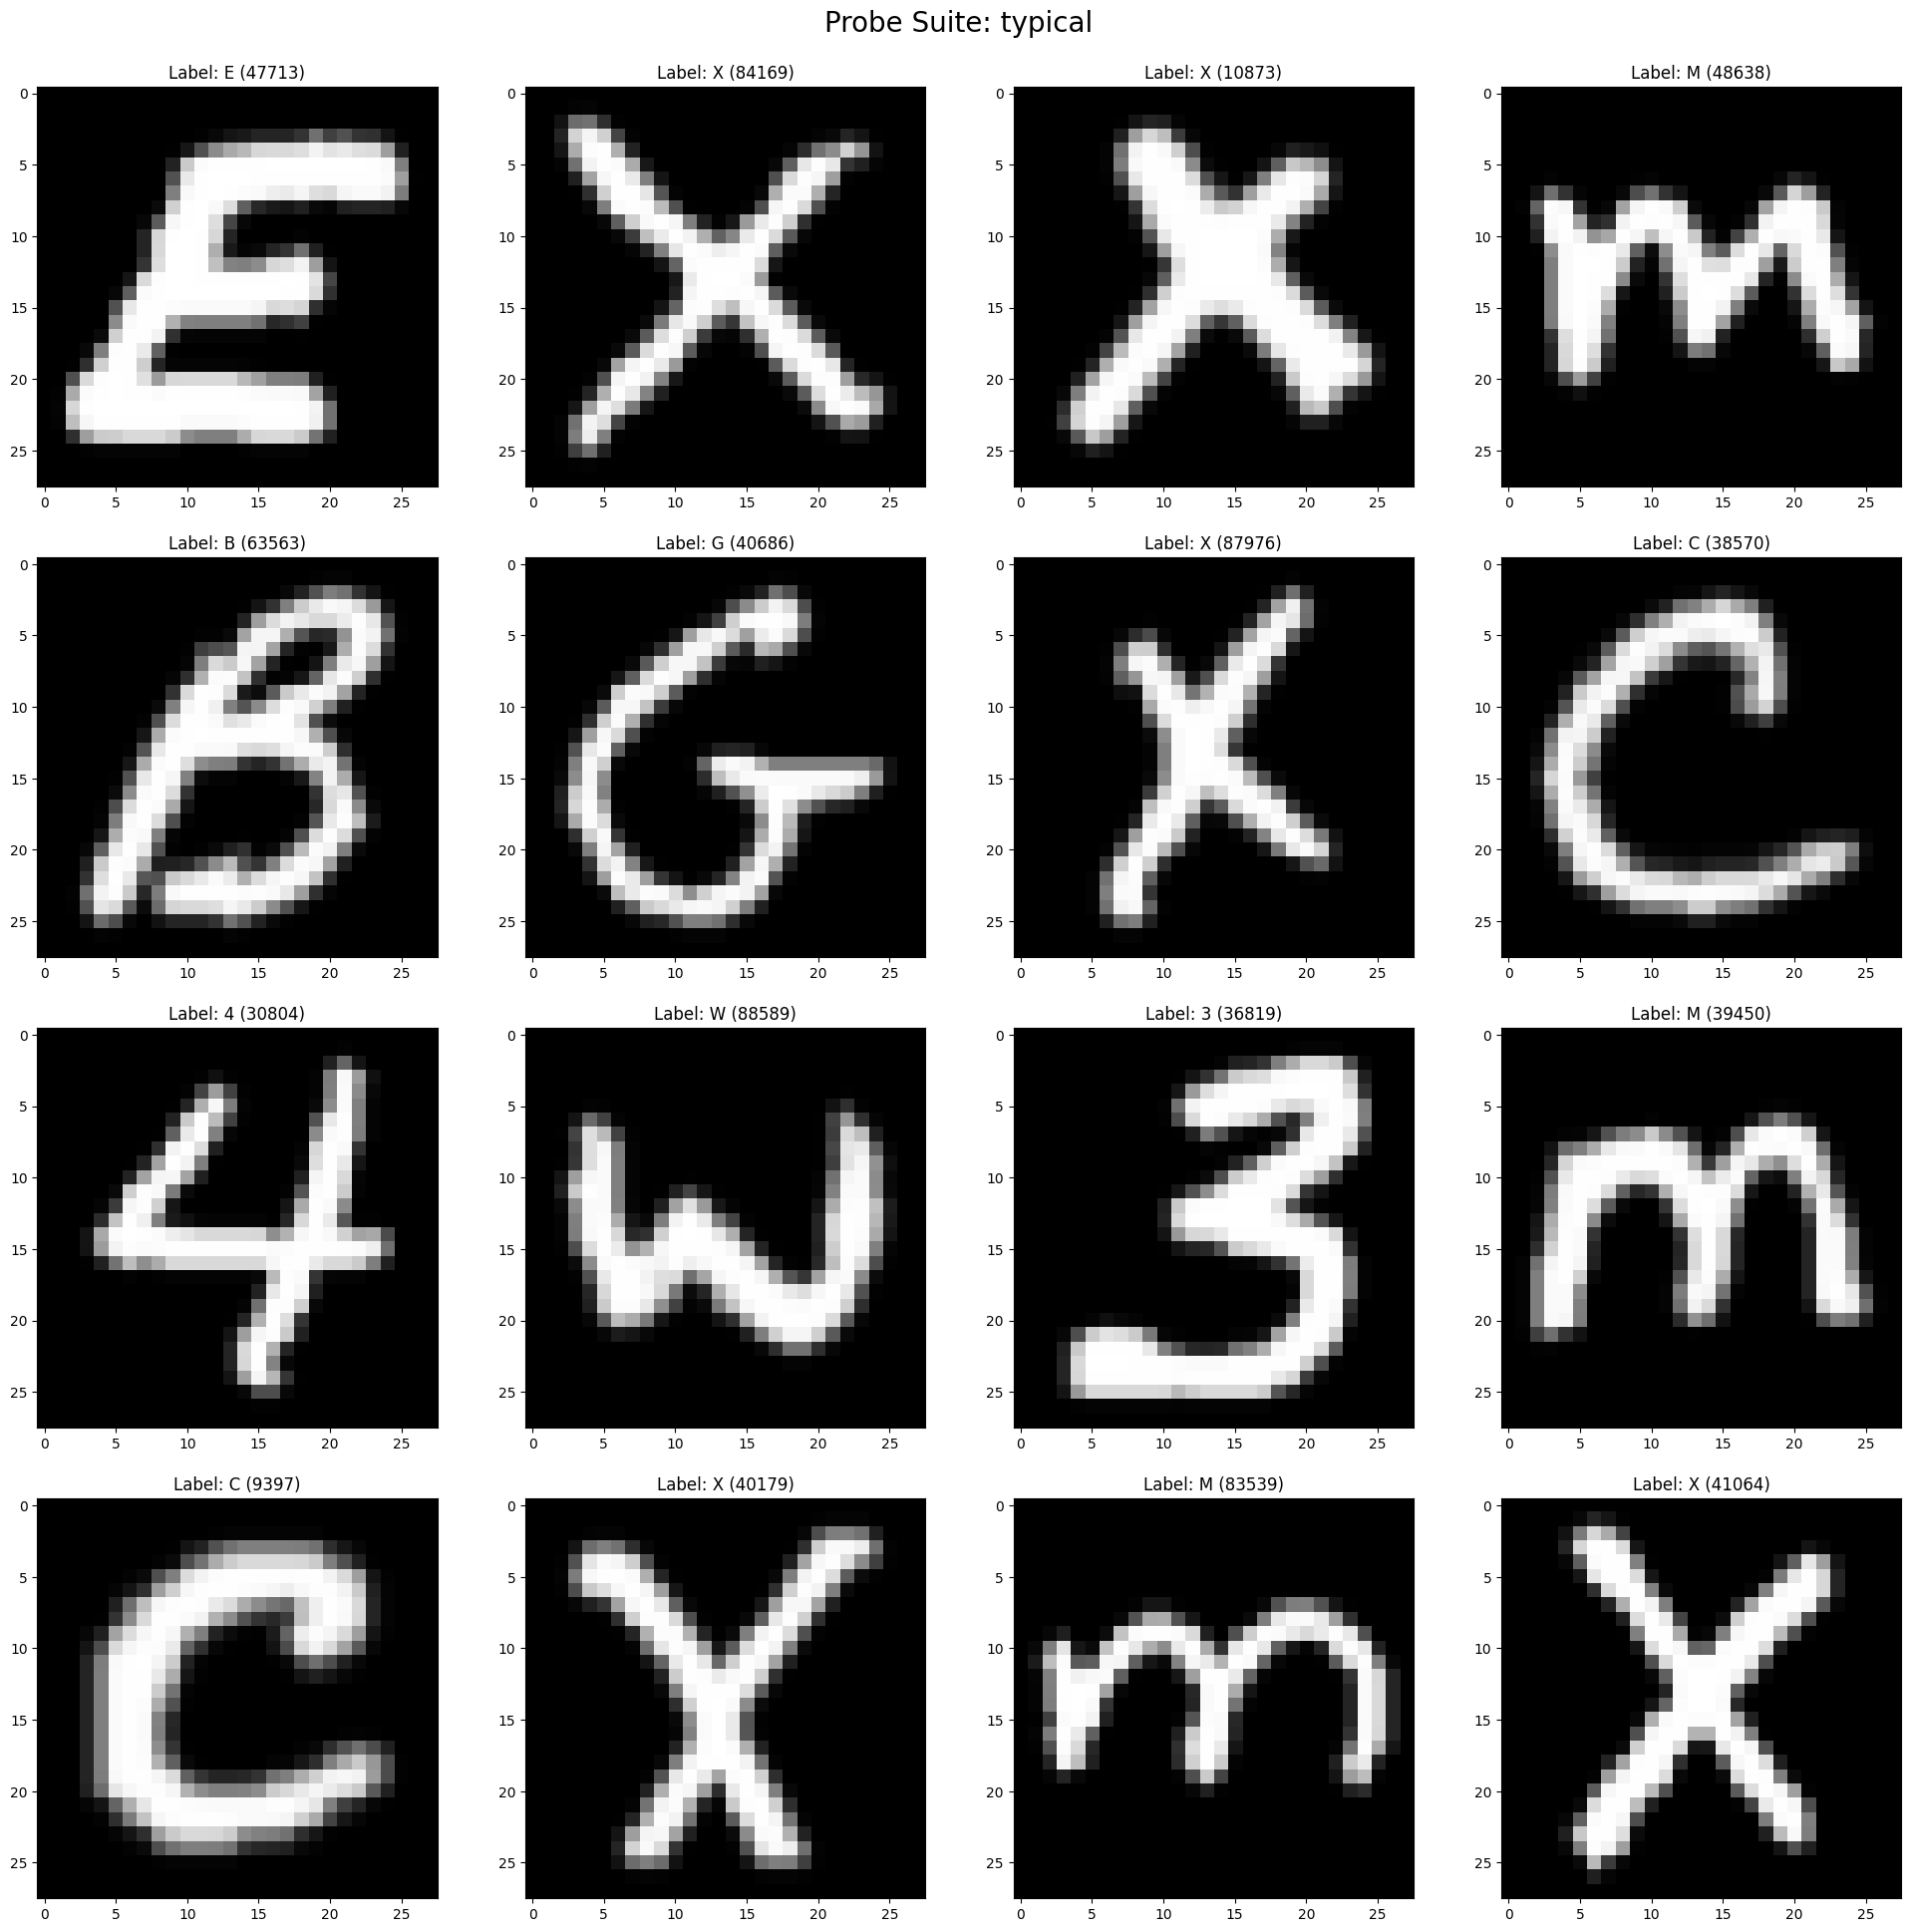

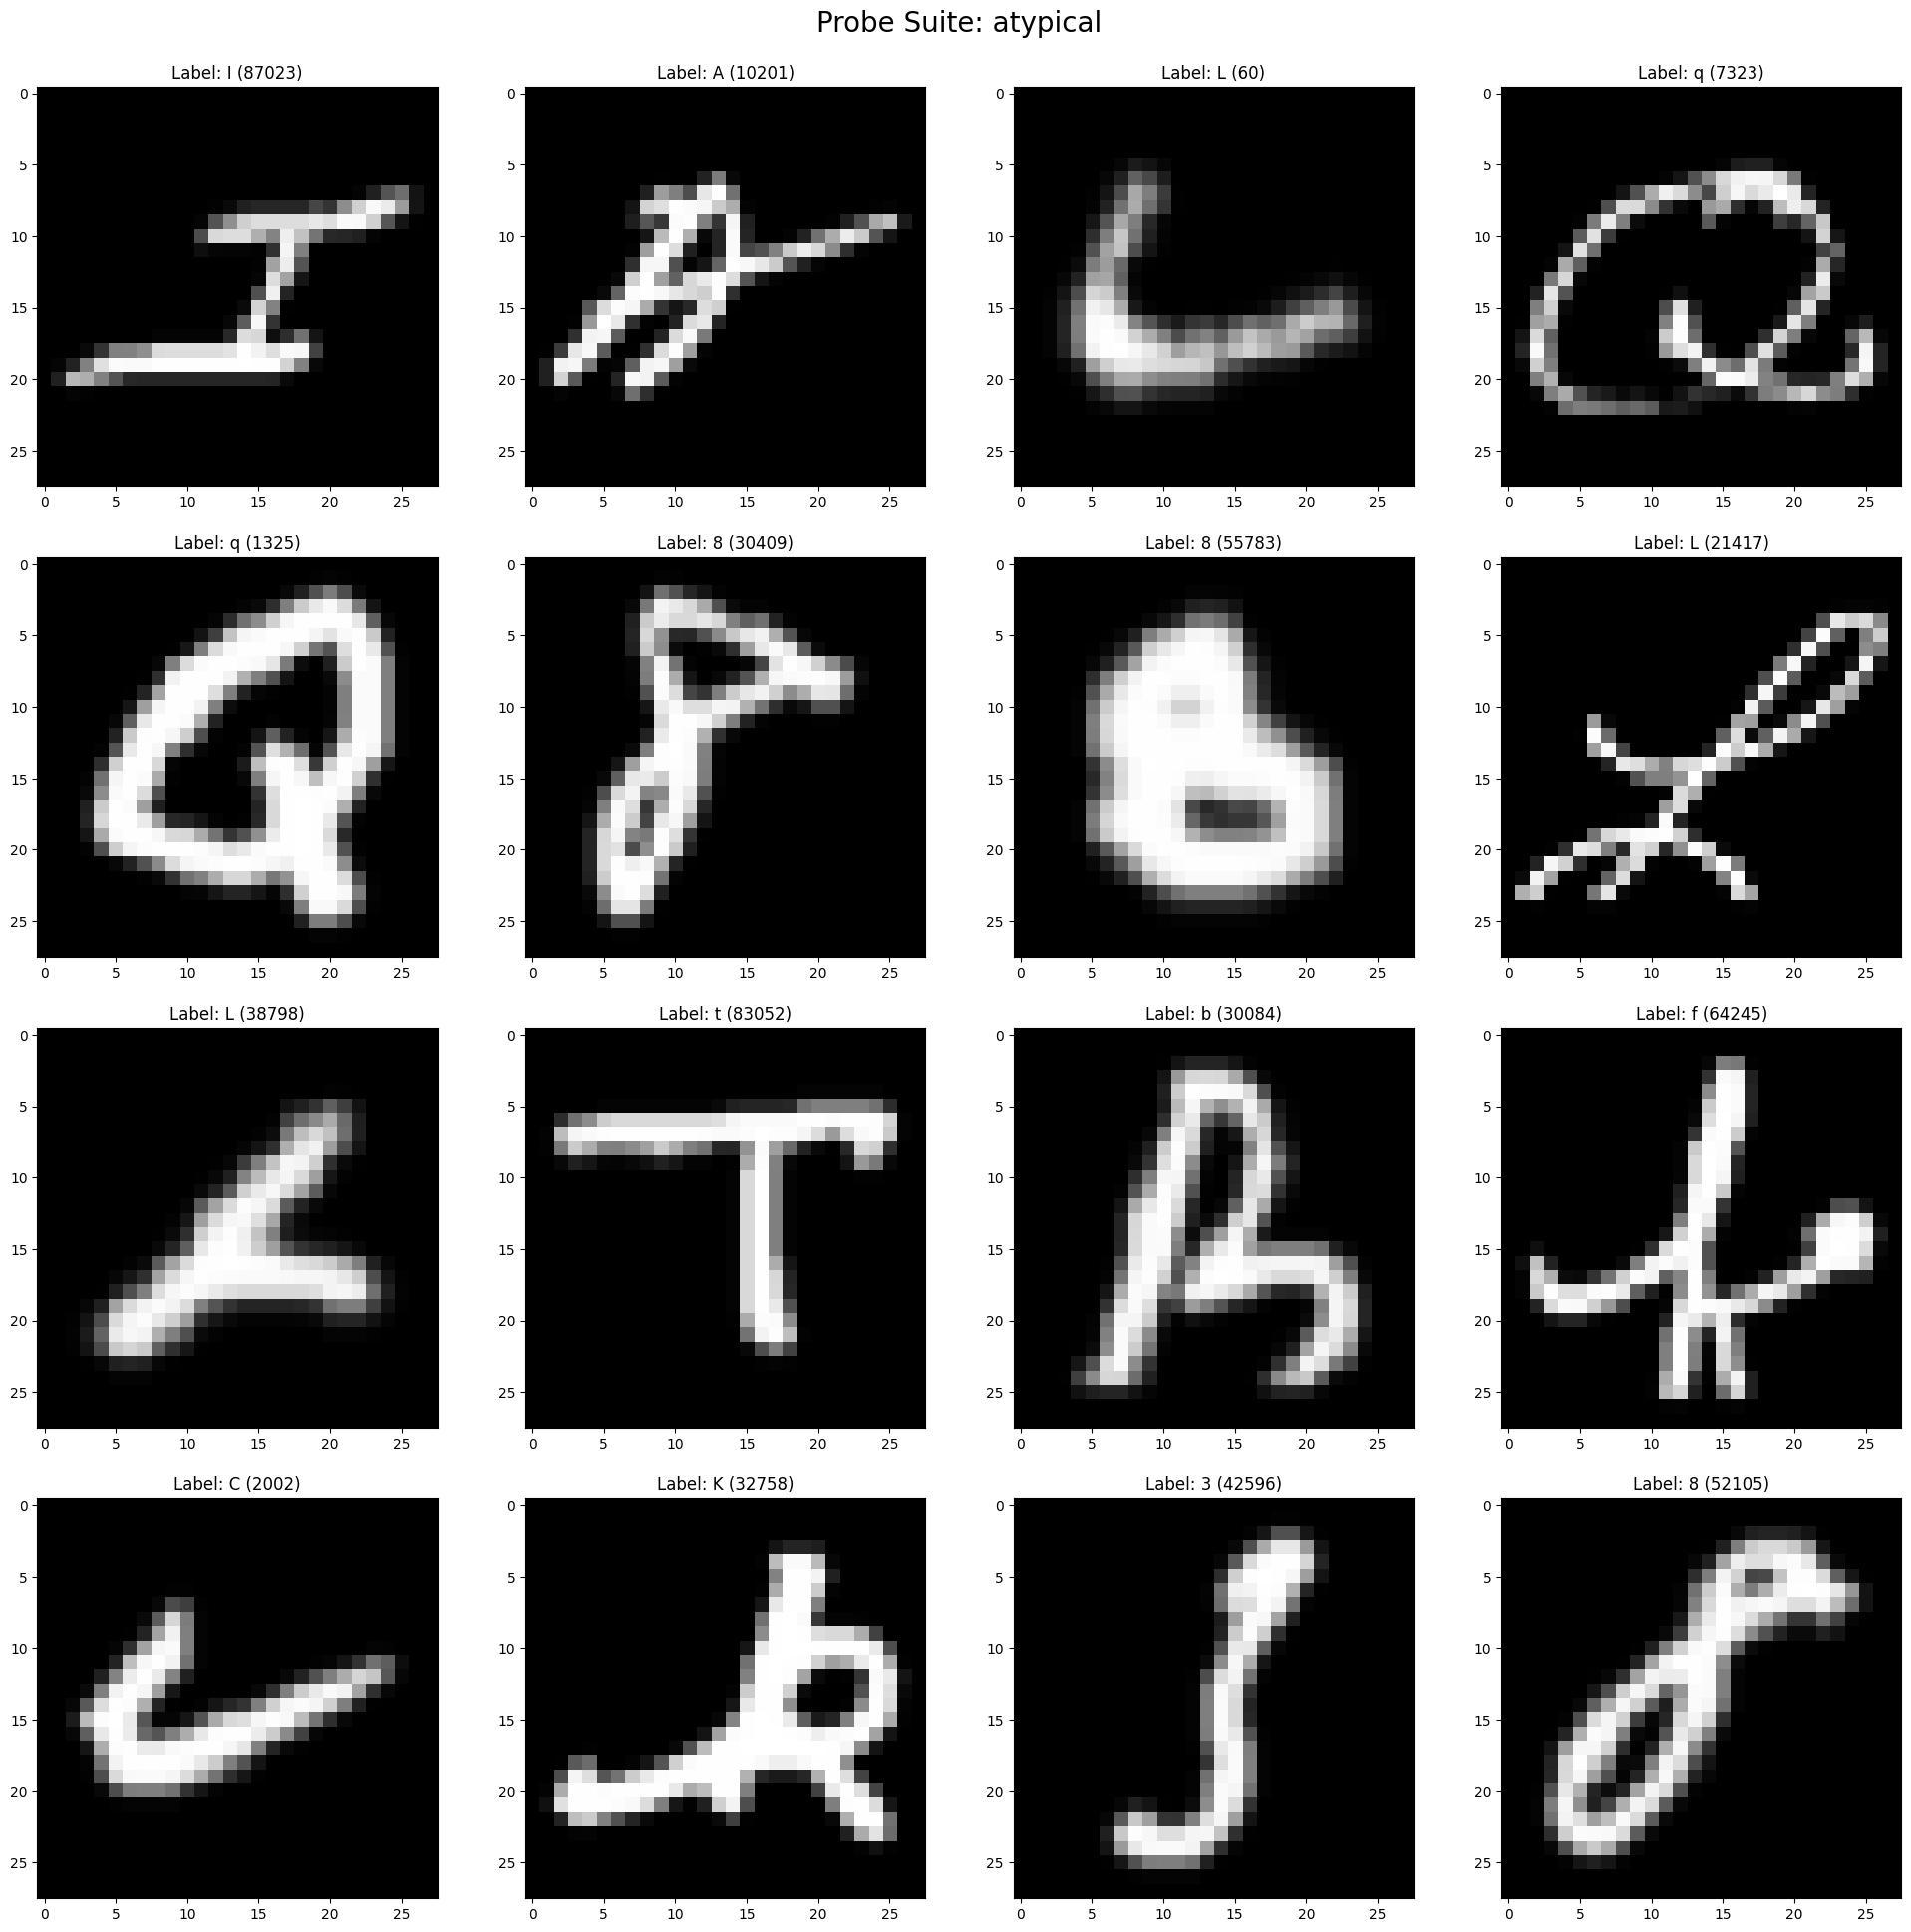

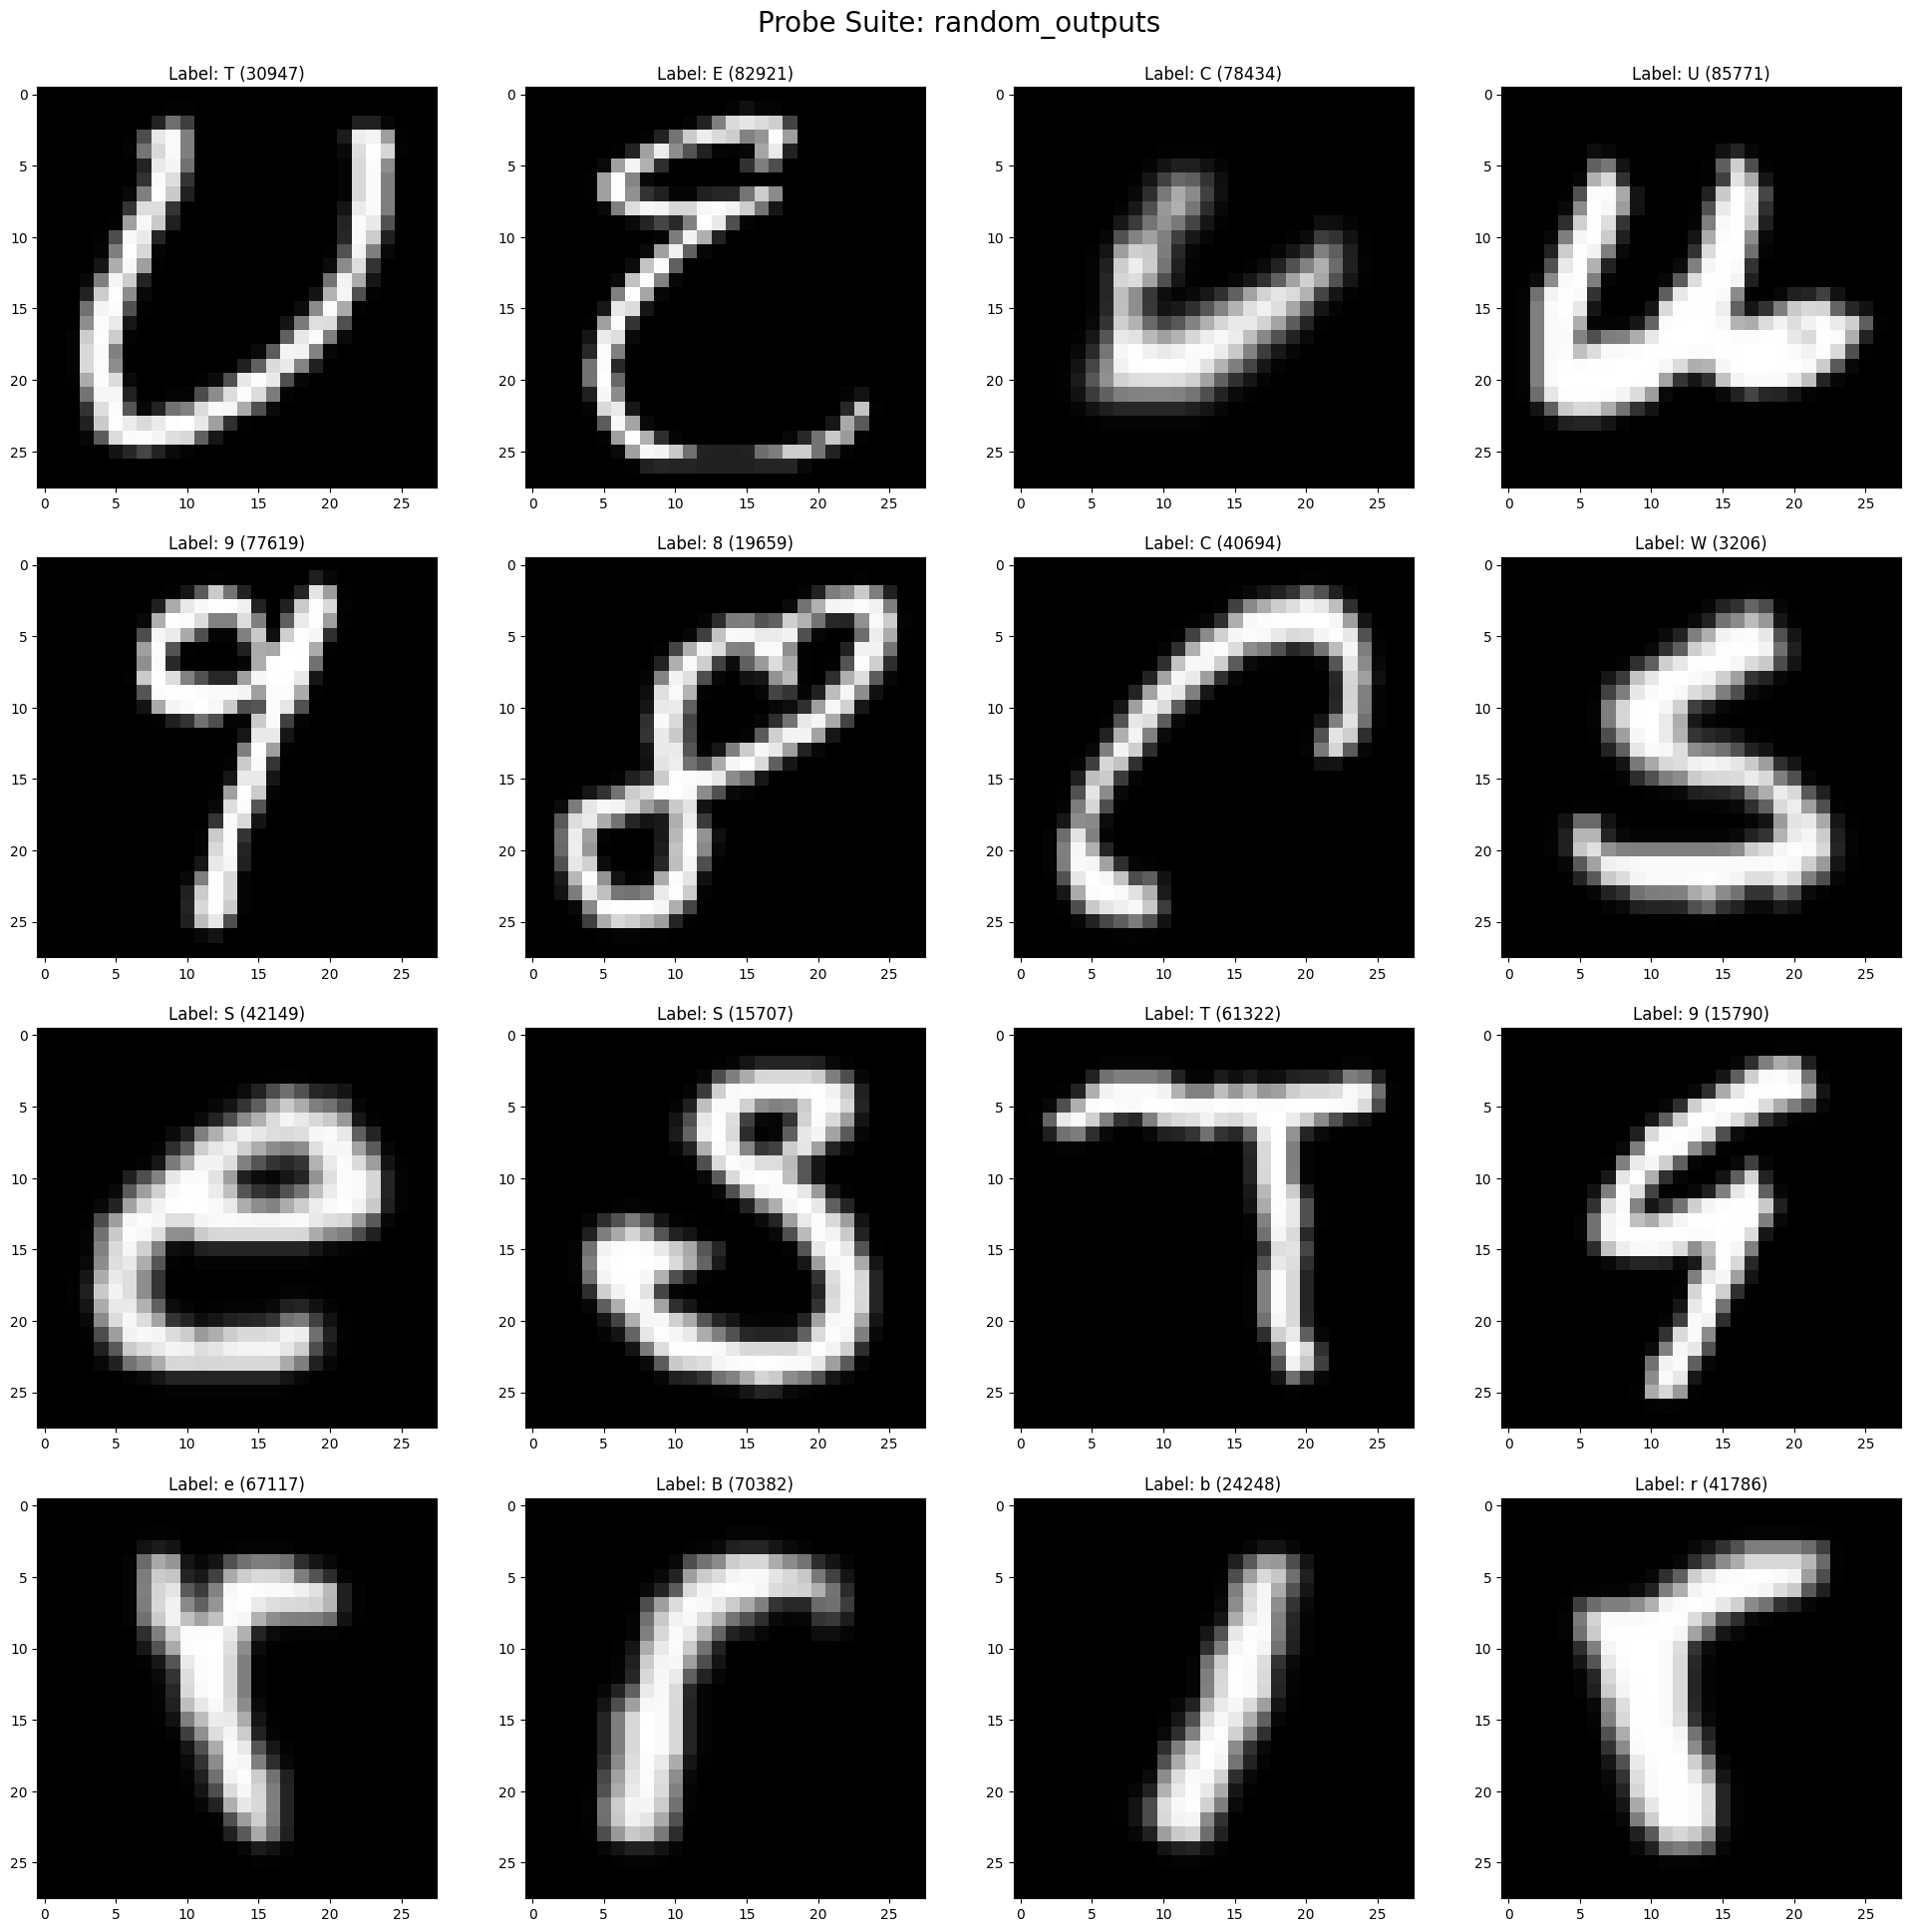

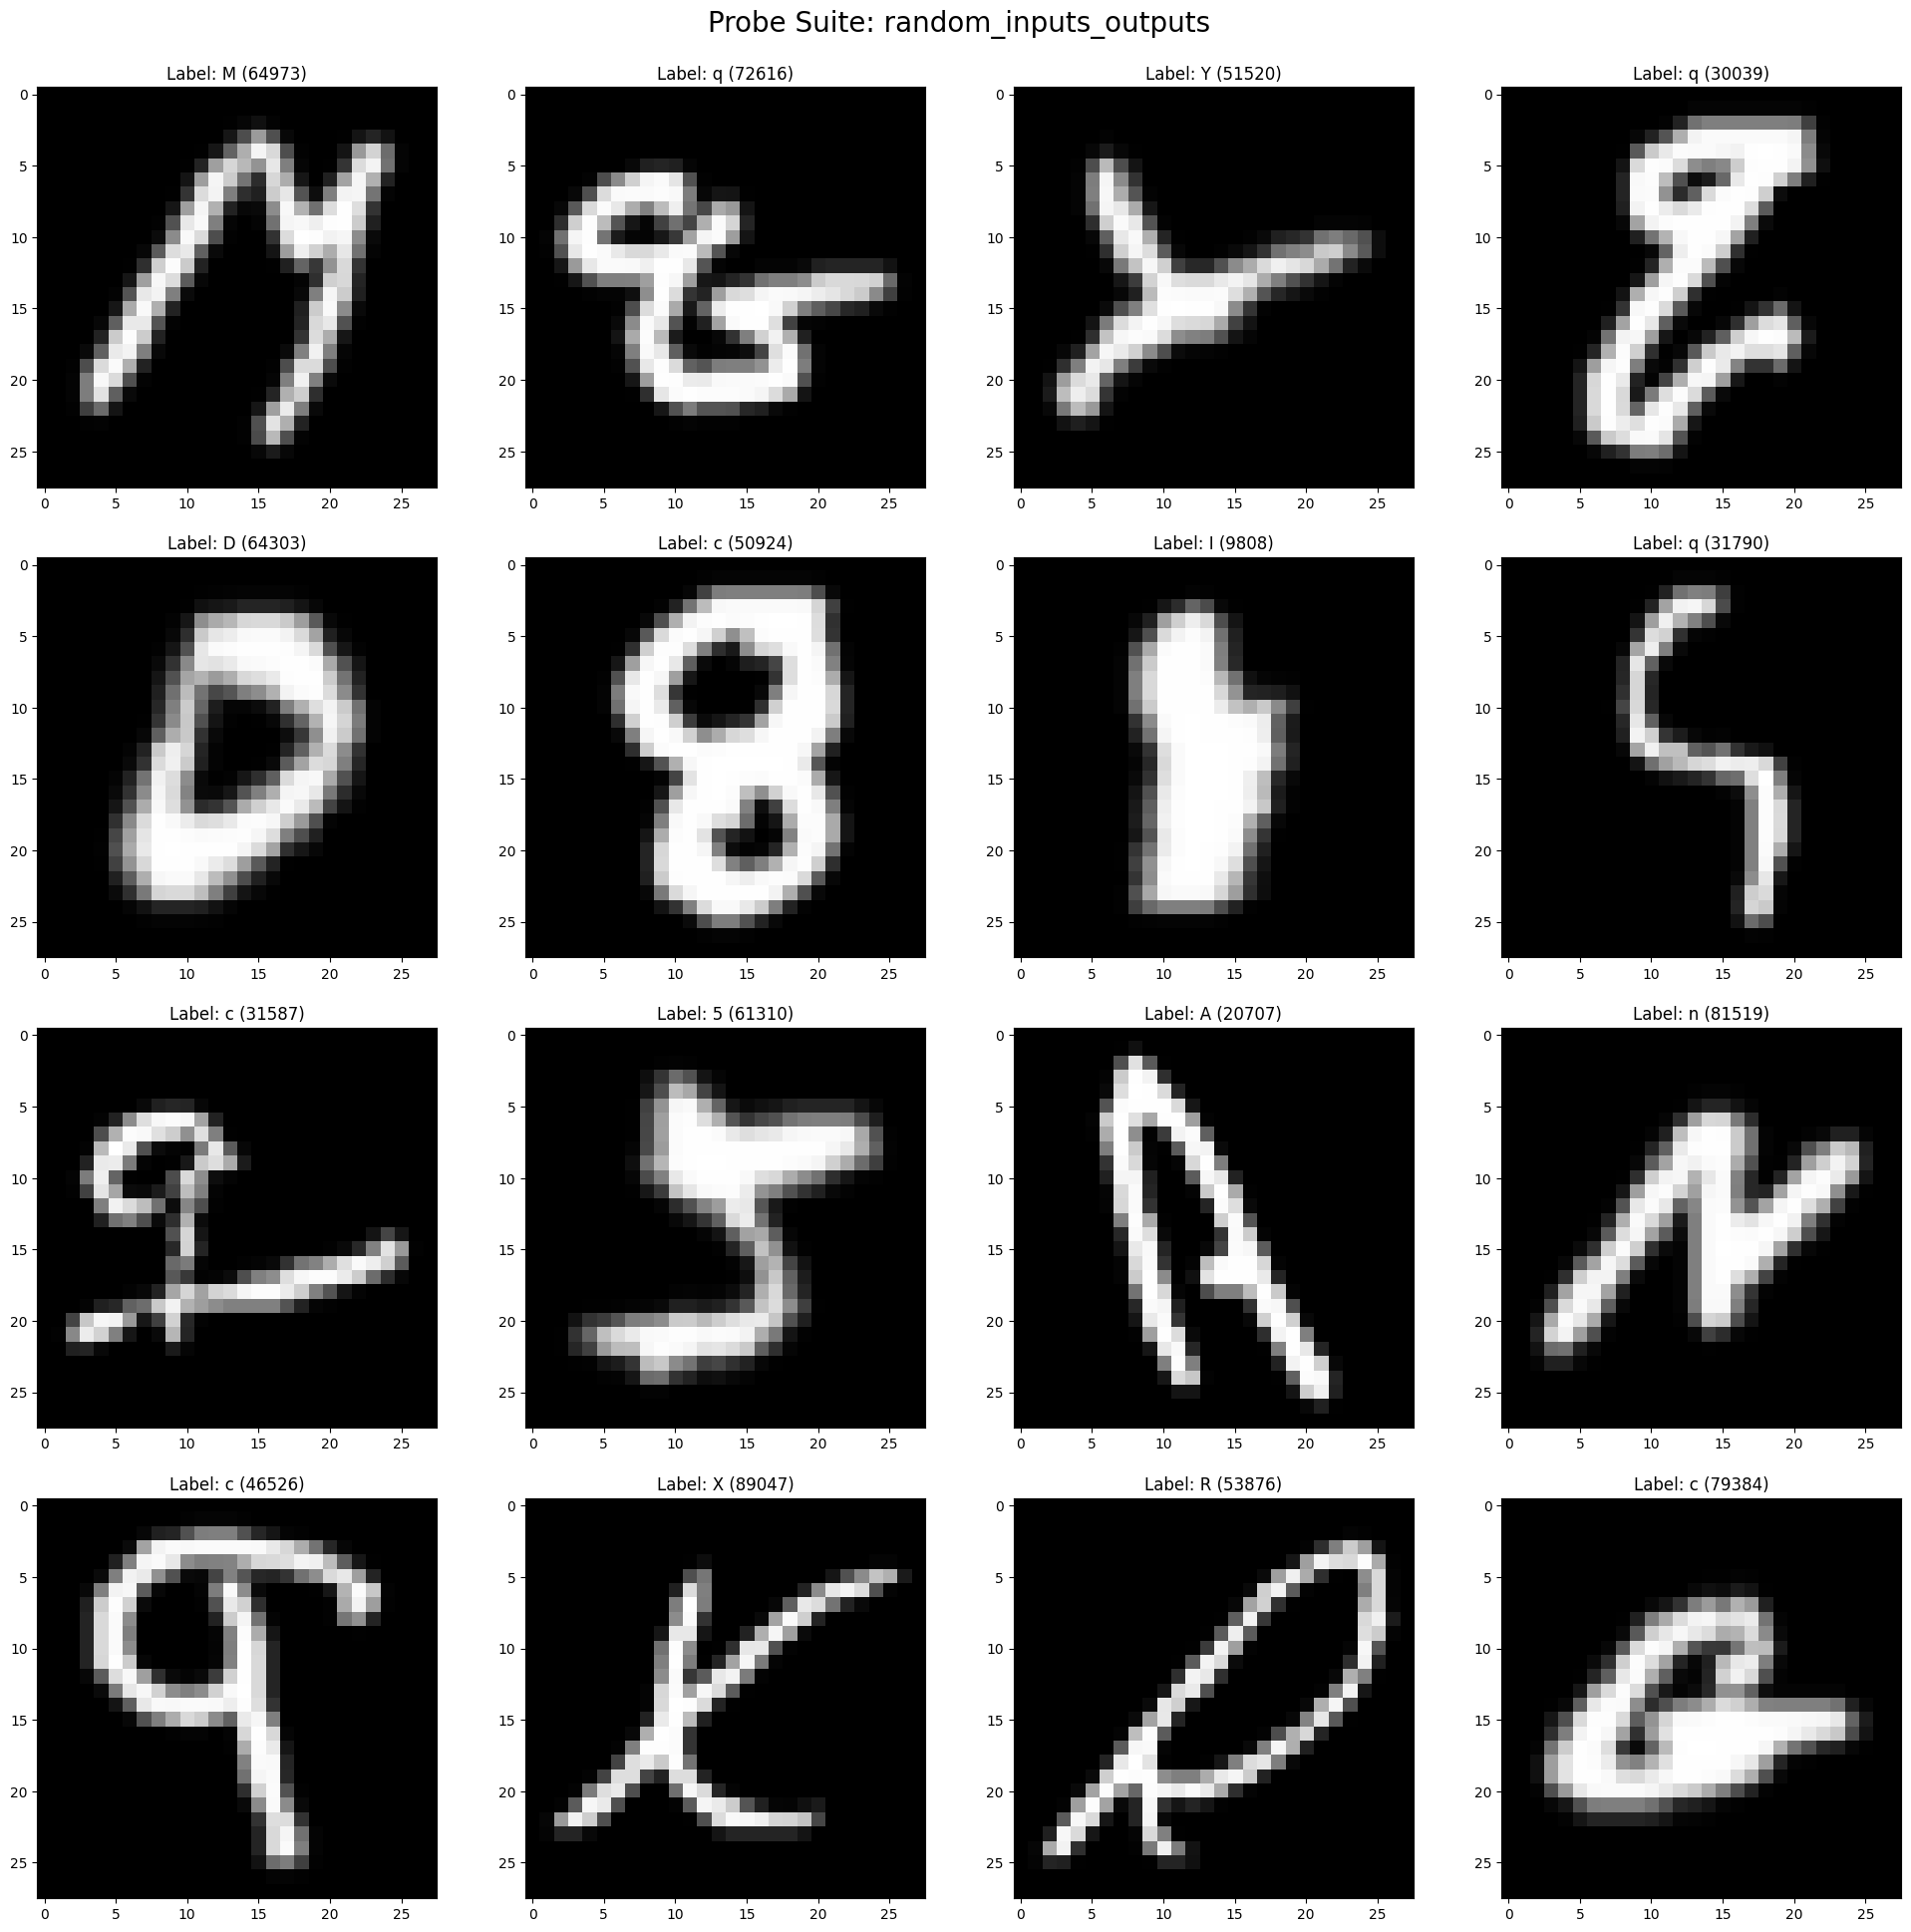

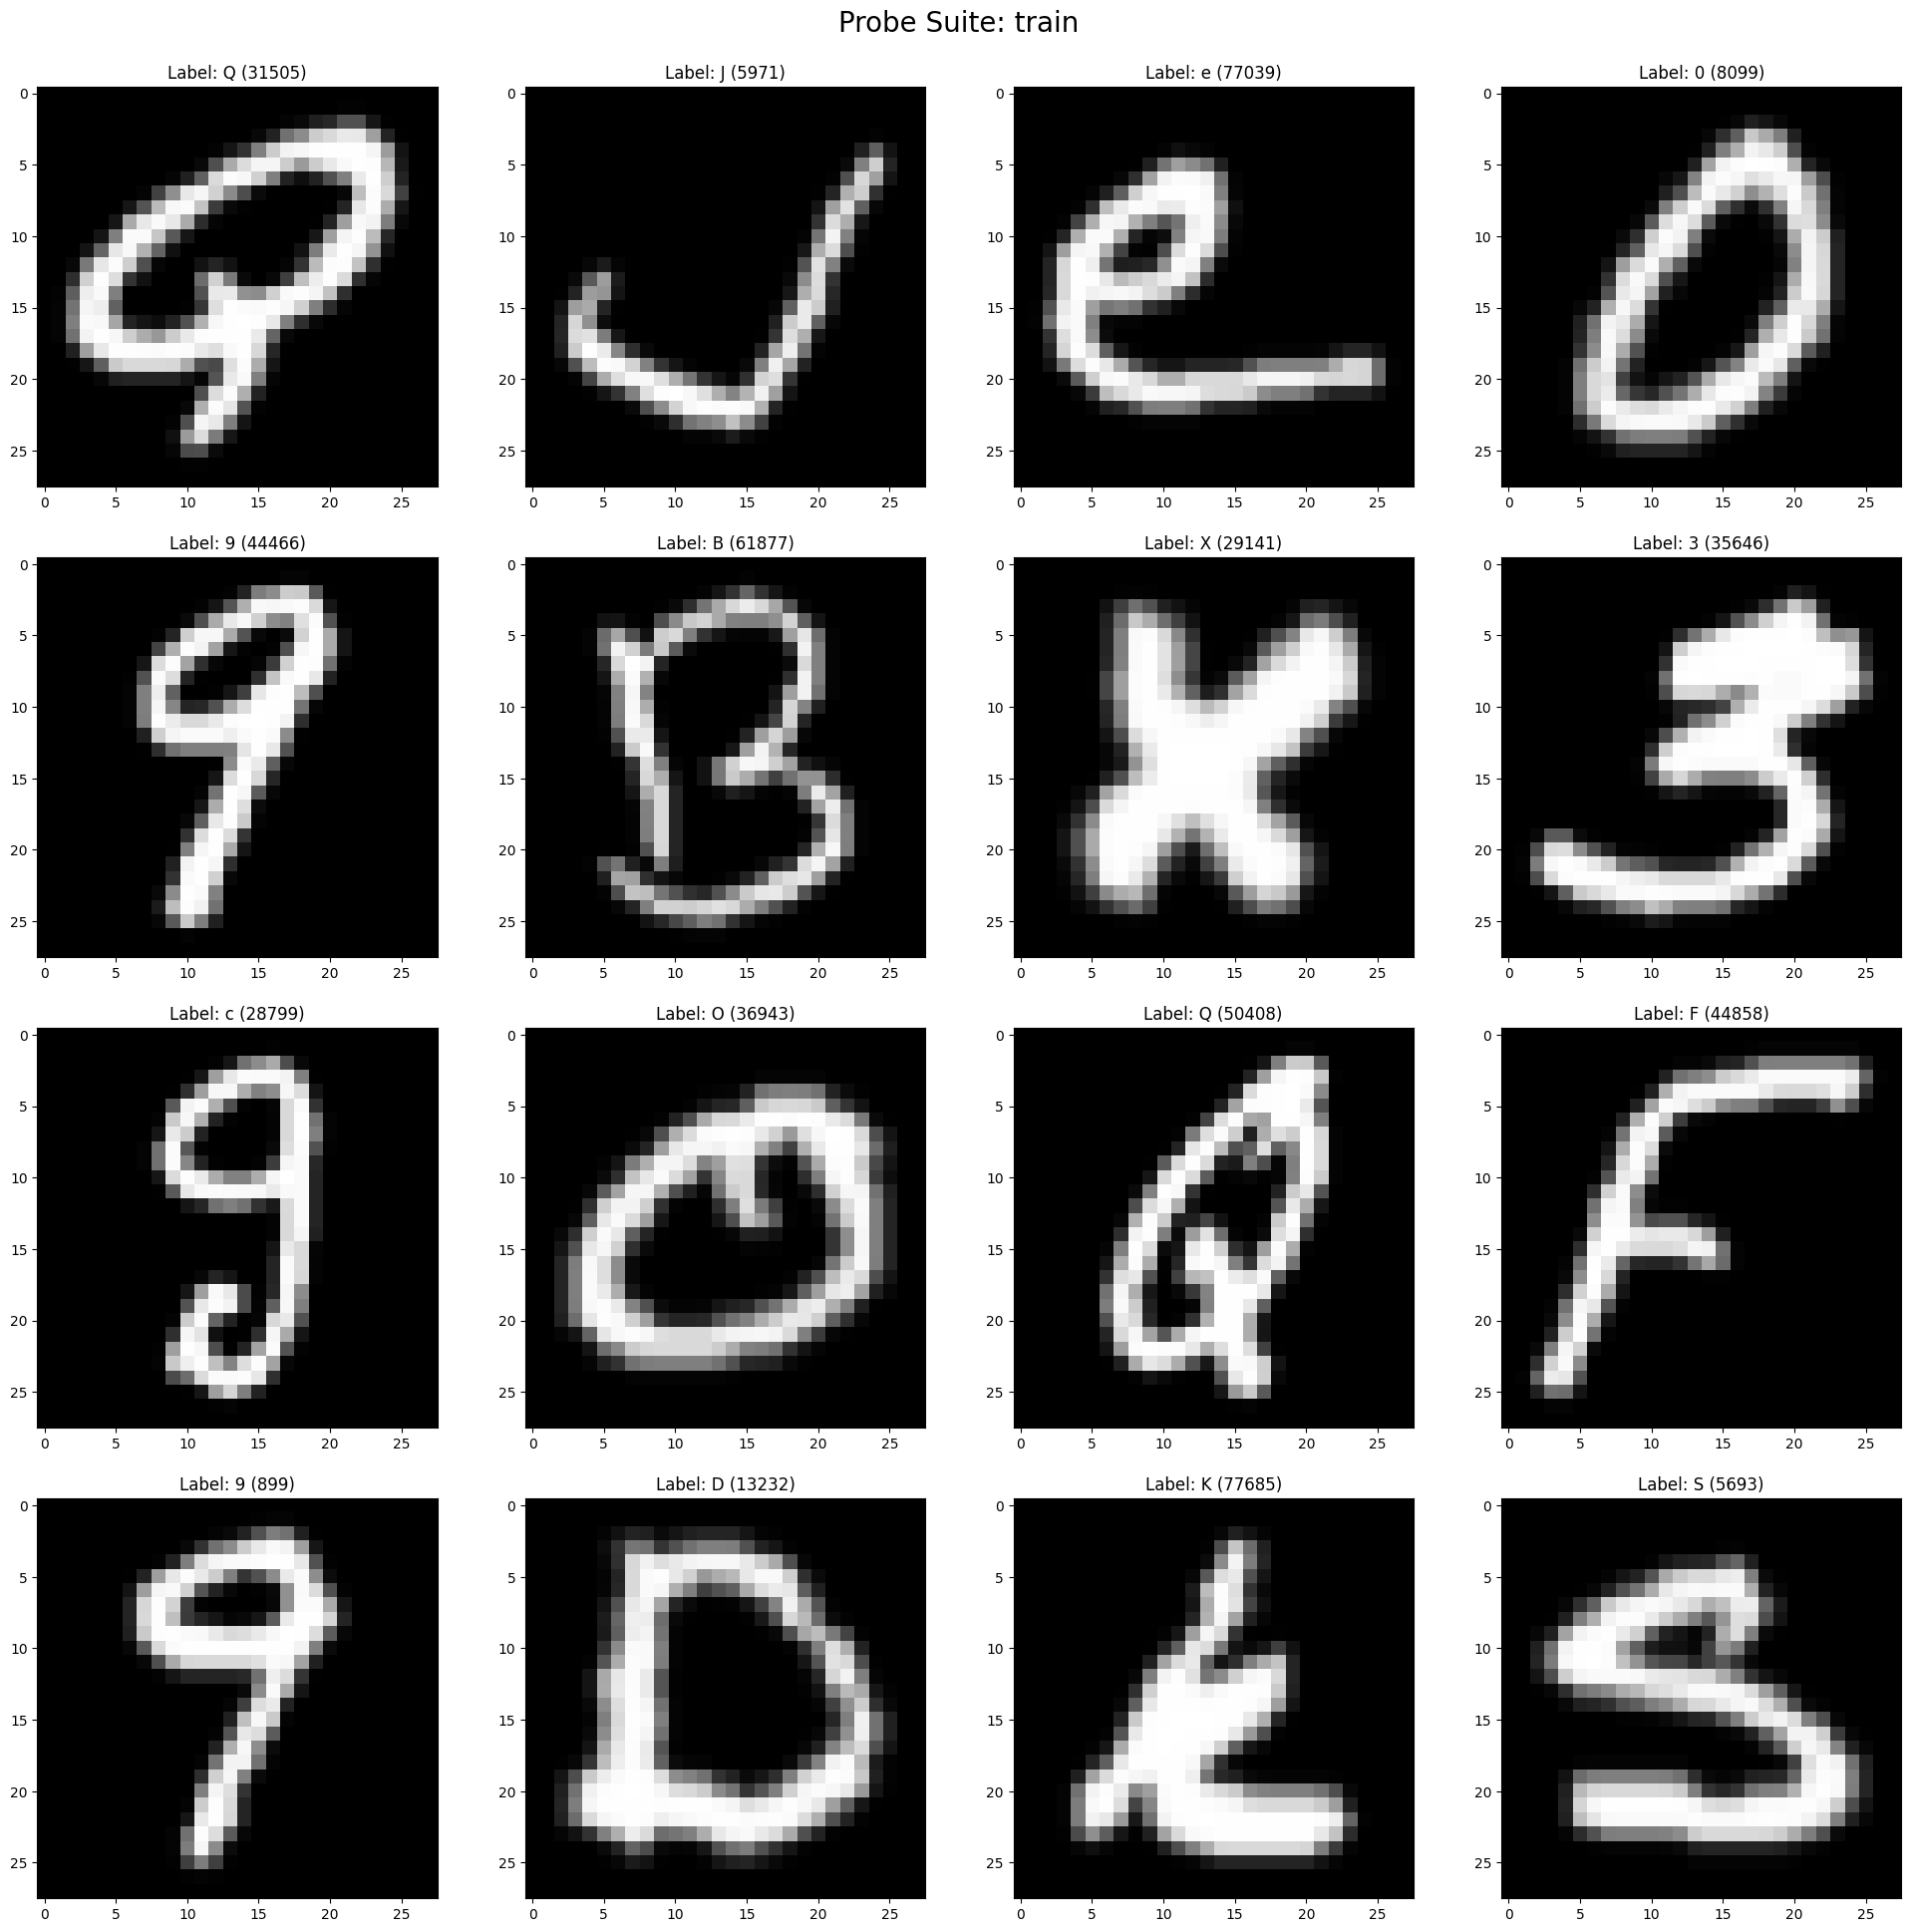

In [18]:
from mapd.visualization.surface_predictions import make_surface_predictions
import matplotlib.pyplot as plt
from string import ascii_uppercase, digits

letters = digits + "ABCDEFGHIJKLMNOPQRSTUVWXYZabdefchnqrt"

labels = {i: l for i, l in enumerate(letters)}

fig = make_surface_predictions(preds, mnist_train, probe_suite="typical", labels=labels, ordered=True)
plt.show(fig)
fig = make_surface_predictions(preds, mnist_train, probe_suite="atypical", labels=labels, ordered=True)
plt.show(fig)
fig = make_surface_predictions(preds, mnist_train, probe_suite="random_outputs", labels=labels, ordered=True)
plt.show(fig)
fig = make_surface_predictions(preds, mnist_train, probe_suite="random_inputs_outputs", labels=labels, ordered=True)
plt.show(fig)
fig = make_surface_predictions(preds, mnist_train, probe_suite="train", labels=labels, ordered=True)
plt.show(fig)

In [15]:
# Print how many of each probe suite is predicted
from collections import Counter

counts = Counter([ps for ps, _ in preds.values()])

In [16]:
counts

Counter({'train': 82934,
         'random_outputs': 3675,
         'atypical': 2218,
         'typical': 1132,
         'random_inputs_outputs': 281})

In [17]:
preds

{0: ('train', 0.9994398),
 1: ('train', 0.9738327),
 2: ('train', 0.99575585),
 3: ('train', 0.9997578),
 4: ('train', 0.998226),
 5: ('train', 0.99122286),
 6: ('train', 0.99677473),
 7: ('train', 0.99264824),
 8: ('train', 0.9507292),
 9: ('train', 0.92554307),
 10: ('train', 0.96513355),
 11: ('train', 0.8798613),
 12: ('train', 0.9979615),
 13: ('train', 0.999729),
 14: ('train', 0.9972568),
 15: ('train', 0.9972197),
 16: ('train', 0.9919849),
 17: ('train', 0.7602837),
 18: ('train', 0.99529594),
 19: ('train', 0.97961676),
 20: ('train', 0.99531794),
 21: ('train', 0.9408598),
 22: ('train', 0.9998385),
 23: ('train', 0.65323055),
 24: ('train', 0.88886386),
 25: ('random_outputs', 0.88792926),
 26: ('train', 0.7711408),
 27: ('random_outputs', 0.4918255),
 28: ('train', 0.9995409),
 29: ('train', 0.97788936),
 30: ('train', 0.977096),
 31: ('train', 0.9872543),
 32: ('train', 0.9225622),
 33: ('atypical', 0.65215737),
 34: ('train', 0.99972504),
 35: ('train', 0.9983728),
 36: 